## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

<figure>
 <img src="output_images/test1.png" width="1280" alt="Combined Image" />
</figure>

## Compute the camera calibration using chessboard images

Function **cv2.calibrateCamera** finds the camera intrinsic and extrinsic parameters from several views of a calibration pattern.
We need distortion coefficients and camera matrix. As an input we provide 3d points in real world space and corresponding 2d points in image plane.<br>
The camera calibration pipeline can be found in *Project/camera_calibration.py*.
To execute camera calibration set **recalibrate** parameters to True and Run.

In [ ]:
# perform camera calibration
[ret, mtx, dist, rvecs, tvecs] = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)
# Undistort image
img_undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)

<figure>
 <img src="write_up_images/undist.png" width="1280" alt="Combined Image" />
</figure>
 <p></p> 
<figure>
 <img src="write_up_images/undist_real.png" width="1280" alt="Combined Image" />
</figure>

## Color spaces and gradient

Next step is to convert undistorted image to binary by applying absolute sobel edge threshold and magnitude thresholds. <br>
Input image is converted into **grayscale** and into **HLS** colour space. From HLS colour space dimension containing **S** channel is extracted. <br>
Result of grayscale are concatenated using **and** operator. Same for S channel. <br>
And two final results united into one using **or** operator.

In [ ]:
# 0. Get S channel from input image
    s_channel_img = get_S_channel(input_img)

    # 1. Calculate absolute threshold and magnitude threshold for grayscale image
    abs_sobel_bin_img = abs_sobel_thresh(input_img, orient='x', thresh=(20, 100))
    mag_thresh_bin_img = mag_thresh(input_img, sobel_kernel=5, mag_thresh=(20, 100))

    # 2.  Calculate absolute threshold and magnitude threshold for s channel image
    abs_sobel_bin_img_gray = abs_sobel_thresh(s_channel_img, orient='x', thresh=(50, 100))
    mag_thresh_bin_img_gray = mag_thresh(s_channel_img, sobel_kernel=15, mag_thresh=(30, 100))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_channel_img)
    combined_binary[((abs_sobel_bin_img == 1) & (mag_thresh_bin_img == 1))
                    | ((abs_sobel_bin_img_gray == 1) | (mag_thresh_bin_img_gray == 1))] = 1

<figure>
 <img src="write_up_images/color_and_mag_thresh.png" width="250%" alt="Combined Image"  />
</figure>

To play around with thresholds value is possible in *Project/combine_thresholds.py*. Parameters can be changes in **convert_and_threshold** function. And to see results set in **main** function for **convert_and_threshold(img, visu = False)** call **visu** parameter to True. Results are written into *test_images/combined_binary* folder and are used in next step - *Project/get_perspective.py*.

## Perspective transformation

Next step is to transform image top-down way. It will allow us to measure the curvation of lanes. And also we can focus only on region where lane lines are present.<br>
In *Project/get_perspective.py* is pipeline for tuning prespective transformation matrix.<br>

First, we need to select source points on an image:

<figure>
 <img src="write_up_images/choose_points_persp.png" width="250%" alt="Combined Image"  />
</figure>

To go through the tunning process, ensure that in **main** function **calculate_perpective_matrix(img, calculate_matrix = True)** is called with **calculate_matrix** parameter set to True. <br>
Points shall be chosen in following order:
* upper left
* upper right
* bottom right
* bottom left
Press **'q'** to quit. <br>
Drawn lines are intended just to visually help to the user to choose good source points. <br>
From the observation if lines are strongly curved, then choose lines which form 'low' trapezium. In case of almost parallel lines its good to form 'high' trapezium with narrow upper edge. <br>
Also left line shall be inside trapezium. <br>
Correctly chosen source and destination points are 75% of sucessful detection.

<figure>
 <img src="write_up_images/choose_points_persp_res.png" width="250%" alt="Combined Image"  />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Strongly curved lines </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="write_up_images/choose_points_persp_res2.png" width="250%" alt="Combined Image"  />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Almost straight lines </p> 
 </figcaption>
</figure>

This is why important to do the thresholding first and then perform tranformation:

<figure>
 <img src="write_up_images/choose_points_persp_res3_convert_first.png" width="250%" alt="Combined Image"  />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The information about left line is almost lost </p> 
 </figcaption>
</figure>
 <p></p> 
 <figure>
 <img src="write_up_images/choose_points_persp_res3_convert_first_diff.png" width="250%" alt="Combined Image"  />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> More information about left line </p> 
 </figcaption>
</figure>

Result are stored into *Project/test_imaes/warped* folder.

## Locate the Lane Lines using histogram

In [23]:
def hist(img):
    [height, width] = img.shape
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[height//2:height,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

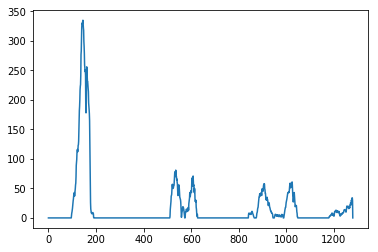

In [24]:
# Create histogram of image binary activations
histogram = hist(combined_binary)

# Visualize the resulting histogram
plt.plot(histogram)

In [25]:
histogram.size

1280

#### Find histogram picks

In [39]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

50 650


In [40]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped*255, binary_warped*255, binary_warped*255))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

        # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

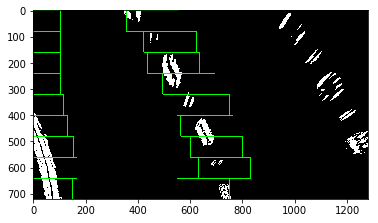

In [41]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(combined_binary)
plt.imshow(out_img)

In [42]:
def fit_polynomial(binary_warped):
   # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fit, right_fit, out_img

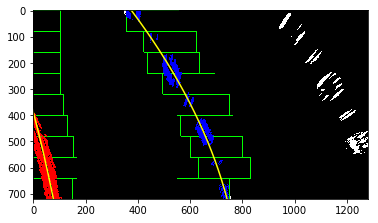

In [43]:
ploty, left_fit, right_fit, out_img = fit_polynomial(combined_binary)
plt.imshow(out_img)

In [45]:
left_fit

array([-9.46704729e-05,  3.36039174e-01, -1.15831631e+02])

## Search from prior

In [273]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# HYPERPARAMETER
# Choose the width of the margin around the previous polynomial to search
def search_around_poly(binary_warped, margin = 100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty

def visualization(binary_warped, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty, 
                  margin = 100):    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

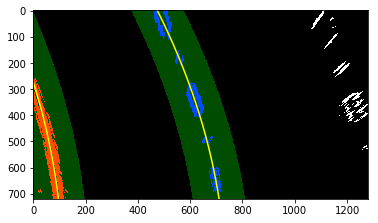

In [274]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty = search_around_poly(combined_binary)
result = visualization(combined_binary, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, left_fitx, right_fitx, ploty)

# View your output
plt.imshow(result)

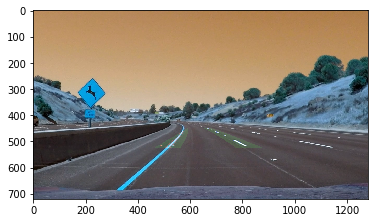

In [277]:
img_size = (result.shape[1], result.shape[0])
M_inv = np.linalg.inv(M)
warped_inv = cv2.warpPerspective(result, M_inv, img_size, flags=cv2.INTER_LINEAR)
# Combine the result with the original image
result = cv2.addWeighted(img_ref_curve, 1, warped_inv, 0.3, 0)
plt.imshow(result)

## Calculate curvation radius

In [237]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [238]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)

2323.548288561163 2163.240271492227


## Real world

In [239]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

2908.049487461011 m 2866.9877753962414 m
